# In this notebook we aim to:
### 1. Fetch current Stock Prices for selective companies
### 2. Fetch all previous Stock Prices for selective companies
### 3. Fetch previous Stock Prices during a specific period for selective companies 
### 4. Fetch previous Stock Prices during a specific period for mass number of companies

We will use Yahoo Finance website to scrape the stock prices from. To understand where stock prices are available, we will navigate to: 
[Yahoo Finance](https://www.finance.yahoo.com/lookup)

Once the page loads, we'll select any Ticker from the list

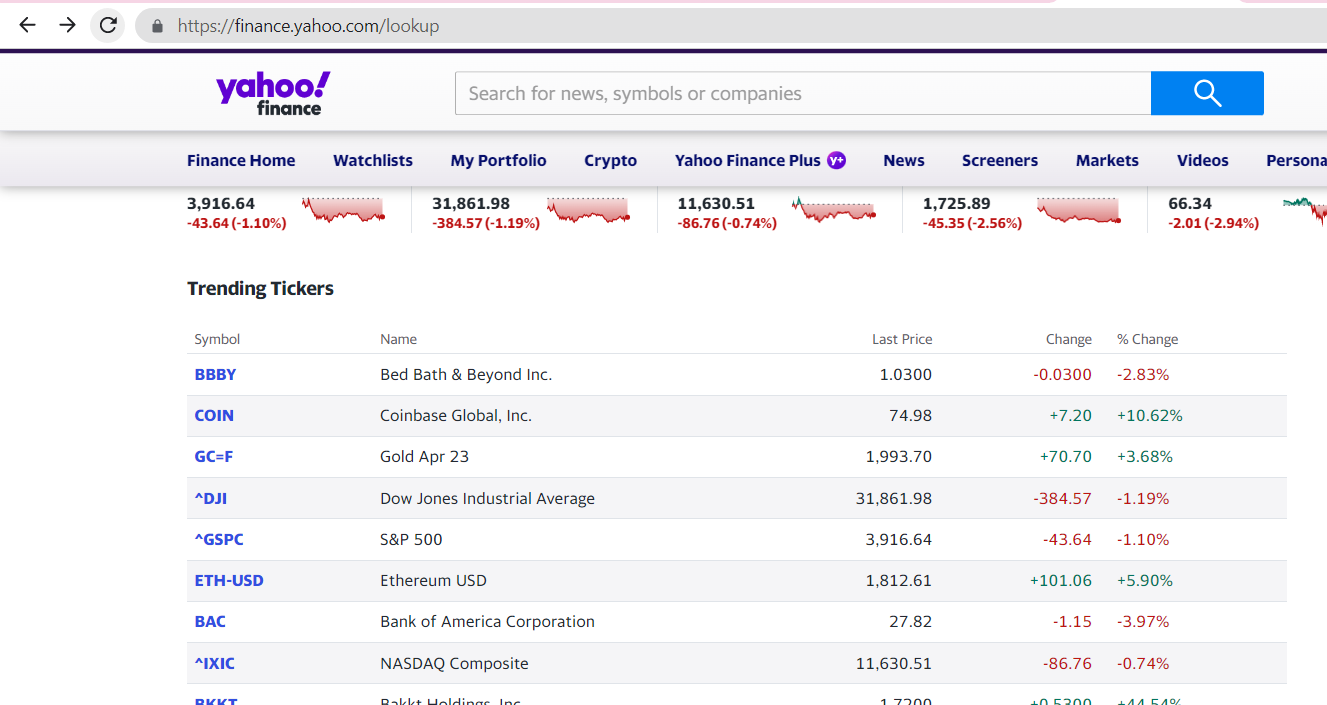

Under the section 'Historical Data' : Select "Max" range of stock prices in the Time Period and set Frequency as "Daily". Click Apply and fetch the url you obtain as that will help us create query urls.


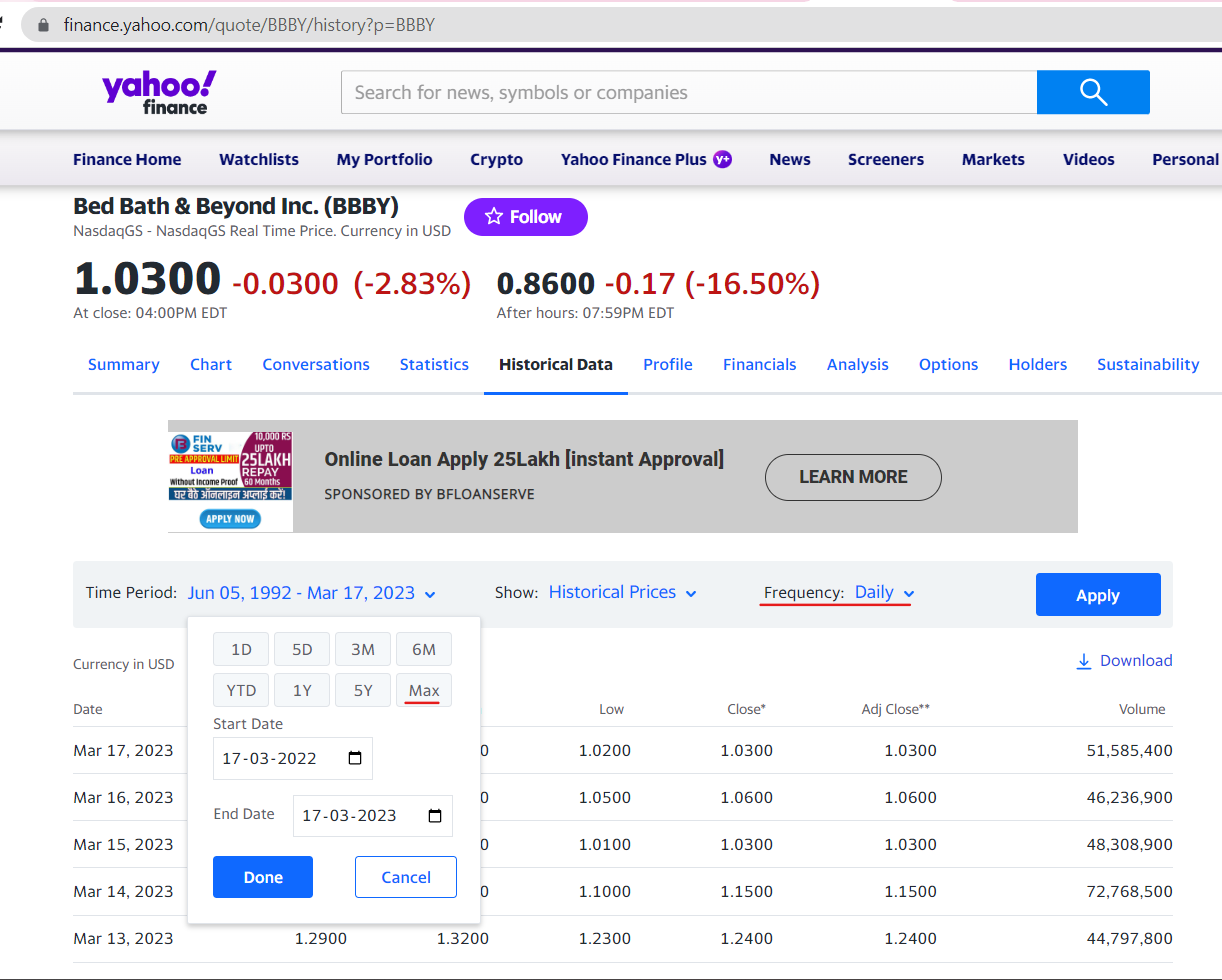

https://finance.yahoo.com/quote/BBBY/history?period1=707702400&period2=1679011200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

#### Importing Libraries

We will need to import the following modules:
* urllib: To get url data
* json: To handle json files
* os: To walk through different directories
* difflib: To get close matches of strings. Helps to find correct stock from the input user gives
* itertools: To repeat same variable to pass in multithreading funciton
* pandas: To handle matrix and csv file
* Pool: To parallelize execution across multiple input values i.e.data parallelism
* datetime: To change unix timestamp to normal date and time. Yahoo query uses unix timestamp

In [1]:
import urllib.request, json , os, difflib, itertools
import pandas as pd
from multiprocessing.dummy import Pool
from datetime import datetime

## AIM 1: Fetch current Stock Prices for selective companies

#### Step 1.1 
We will get the current Stock Price for Apple. We first need to identify the Ticker for Apple. You can either do a quick web search or use the Quick Lookup function on [Yahoo Finance lookup page](https://finance.yahoo.com/lookup)

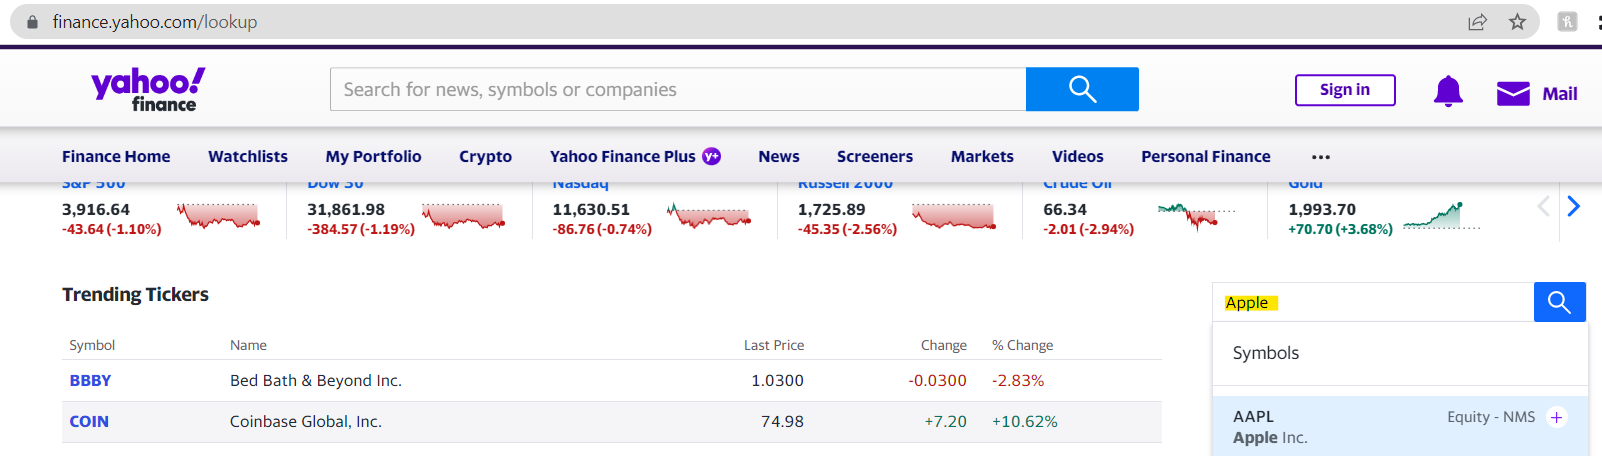

#### Step 1.2 Set query URL
The URL for APPL should look like this:

In [2]:
query_url="https://query1.finance.yahoo.com/v8/finance/chart/AAPL?symbol=AAPL"

##### Why 'query1' in the URL you ask?

Yahoo has gone to a Reactjs front end which means if you analyze the request headers from the client to the backend you can get the actual JSON they use to populate the client side stores.

##### Hosts:
* `query1.finance.yahoo.com` HTTP/1.0
* `query2.finance.yahoo.com` HTTP/1.1 [difference between HTTP/1.0 & HTTP/1.1](https://stackoverflow.com/questions/246859/http-1-0-vs-1-1)  

#### Step 1.3 Get JSON data from webpage

In [3]:
try:
    with urllib.request.urlopen(query_url) as url:
        parsed = json.loads(url.read().decode())
except:
    pass

#### Step 1.4 Investigate JSON variable to see which key has the current Stock Price

In [4]:
parsed

{'chart': {'result': [{'meta': {'currency': 'USD',
     'symbol': 'AAPL',
     'exchangeName': 'NMS',
     'instrumentType': 'EQUITY',
     'firstTradeDate': 345479400,
     'regularMarketTime': 1679083205,
     'gmtoffset': -14400,
     'timezone': 'EDT',
     'exchangeTimezoneName': 'America/New_York',
     'regularMarketPrice': 155.0,
     'chartPreviousClose': 155.85,
     'previousClose': 155.85,
     'scale': 3,
     'priceHint': 2,
     'currentTradingPeriod': {'pre': {'timezone': 'EDT',
       'end': 1679059800,
       'start': 1679040000,
       'gmtoffset': -14400},
      'regular': {'timezone': 'EDT',
       'end': 1679083200,
       'start': 1679059800,
       'gmtoffset': -14400},
      'post': {'timezone': 'EDT',
       'end': 1679097600,
       'start': 1679083200,
       'gmtoffset': -14400}},
     'tradingPeriods': [[{'timezone': 'EDT',
        'end': 1679083200,
        'start': 1679059800,
        'gmtoffset': -14400}]],
     'dataGranularity': '1m',
     'range': '1

We see that the current Stock Price is captured in "regularMarketPrice" of this JSON dictionary

#### Step 1.5 Final output

In [6]:
print("Stock price for Apple is: ",parsed['chart']['result'][0]['meta']['regularMarketPrice'])

Stock price for Apple is:  155.0


Check this with Yahoo Finance site for Apple

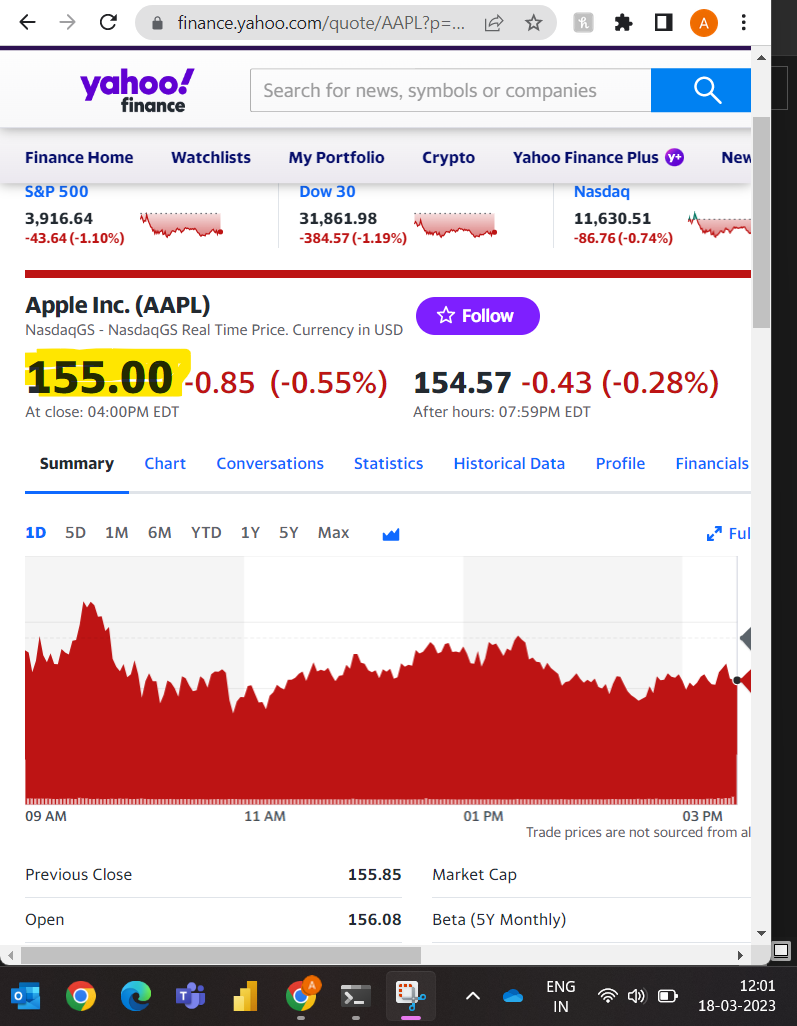

## AIM 2: Fetch all previous Stock Prices for selective companies

#### Step 2.1 Create reusable function to scrape stock prices
For the next parts of our solution, we will create a function 'get_historic_price' which will  take 2 input arguments: 
1. query_url - the url from which data will be scraped
2. csv_path - the file path where the scraped data will be stored

- We will get ticker from our query_url into the 'stock_id' variable.
- In case the Stock Price historic data file already exists, we will update the data. Otherwise we will create a new file.
- We are getting the following details for each stock ticker: Low value, Open value, Volume, High value, Close value, Adjusted Close value

In [7]:
def get_historic_price(query_url,csv_path):
    
    stock_id=query_url.split("&period")[0].split("symbol=")[1]
    
    if os.path.exists(csv_path+stock_id+'.csv') and os.stat(csv_path+stock_id+'.csv').st_size != 0:
        print("<<<  Historical data of "+stock_id+" already exists, Updating data...")

    try:
        with urllib.request.urlopen(query_url) as url:
            parsed = json.loads(url.read().decode())
    except:
        print("|||  Historical data of "+stock_id+" doesn't exist")
        return
    
    else:

        try:
            Date=[]
            for i in parsed['chart']['result'][0]['timestamp']:
                Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d-%m-%Y'))
                
            Low=parsed['chart']['result'][0]['indicators']['quote'][0]['low']
            Open=parsed['chart']['result'][0]['indicators']['quote'][0]['open']
            Volume=parsed['chart']['result'][0]['indicators']['quote'][0]['volume']
            High=parsed['chart']['result'][0]['indicators']['quote'][0]['high']
            Close=parsed['chart']['result'][0]['indicators']['quote'][0]['close']
            Adjusted_Close=parsed['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

            df=pd.DataFrame(list(zip(Date,Low,Open,Volume,High,Close,Adjusted_Close)),columns =['Date','Low','Open','Volume','High','Close','Adjusted Close'])

            if os.path.exists(csv_path+stock_id+'.csv'):
                os.remove(csv_path+stock_id+'.csv')
            df.to_csv(csv_path+stock_id+'.csv', sep=',', index=None)
            print(">>>  Historical data of "+stock_id+" saved")
            return
        except:
            print(">>>  Historical data of "+stock_id+" exists but has no trading data")

#### Step 2.2 Setting query URL

The URL for APPL should look like this:

In [8]:
query_url1="https://query1.finance.yahoo.com/v8/finance/chart/GOOGL?symbol=GOOGL&period1=0&period2=9999999999&interval=1d&includePrePost=true&events=div%2Csplit"

Note: period1 & period2 are the unix timestamps. period1 should be set to 0 and period2 should be set to 9999999999 for scraping all historic data

#### Step 2.3 Setting csv output file path

In [9]:
csv_path1 = os.getcwd()+os.sep+"all_historic_data_Google"+os.sep+"csv"+os.sep

## Create directory if not already present
if not os.path.isdir(csv_path1):
    os.makedirs(csv_path1)

#### Step 2.4 Scrape data using 'get_historic_price' function

In [10]:
get_historic_price(query_url1, csv_path1)

>>>  Historical data of GOOGL saved


#### Step 2.5 (optional) Check output

In [11]:
df_google = pd.read_csv(csv_path1+"GOOGL.csv")
df_google.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.401401,2.502503,893181924,2.604104,2.511011,2.511011
1,20-08-2004,2.515015,2.527778,456686856,2.729730,2.710460,2.710460
2,23-08-2004,2.728979,2.771522,365122512,2.839840,2.737738,2.737738
3,24-08-2004,2.591842,2.783784,304946748,2.792793,2.624374,2.624374
4,25-08-2004,2.599600,2.626627,183772044,2.702703,2.652653,2.652653


## AIM 3: Fetch previous Stock Prices during a specific period for selective companies 

We already have a reusable function to scrape historic Stock Price for a specific query URL. All we need to do now is customize our query URL for a specific period of interest. Let's say we want to fetch Stock Prices in January 2022 for Meta. We will need to figure out the UNIX timestamp for Jan 1, 2022 and Jan 31, 2022

#### Step 3.1 Get UNIX timestamp for the specific period of interest

Navigate to [Unix Timestamp](https://www.unixtimestamp.com/)

Enter the GMT Date & Time, click on Convert

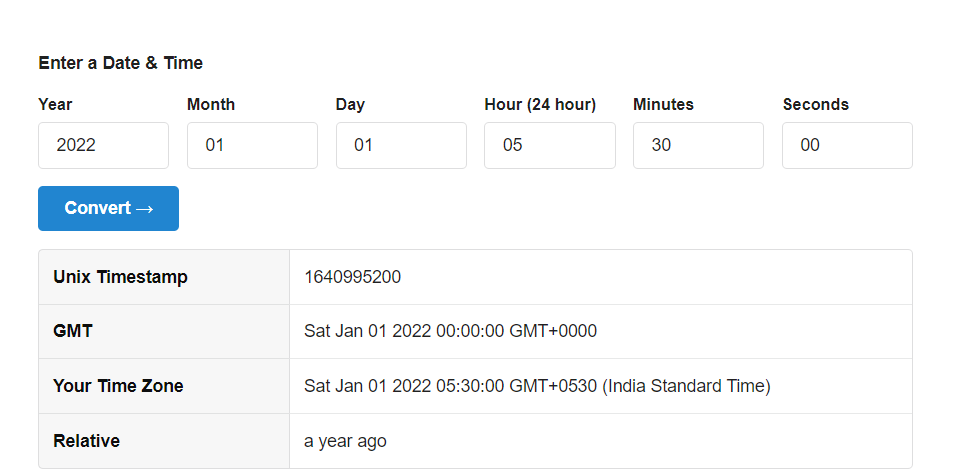

Therefore, we'll set period1 as "1640995200". Similary we'll set period2 as "1643587200" in our Query URL

#### Step 3.2 Setting query URL

In [12]:
query_url2="https://query1.finance.yahoo.com/v8/finance/chart/META?symbol=META&period1=1640995200&period2=1643587200&interval=1d&includePrePost=true&events=div%2Csplit"

#### Step 3.3 Setting csv output file path

In [13]:
csv_path2 = os.getcwd()+os.sep+"Jan2022_data_Meta"+os.sep+"csv"+os.sep

## Create directory if not already present
if not os.path.isdir(csv_path2):
    os.makedirs(csv_path2)

#### Step 3.4 Scrape data using 'get_historic_price' function

In [14]:
get_historic_price(query_url2, csv_path2)

>>>  Historical data of META saved


#### Step 3.5 (optional) Check output

In [15]:
df_meta = pd.read_csv(csv_path2+"META.csv")
df_meta.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,03-01-2022,337.190002,338.299988,14537900,341.079987,338.540009,338.540009
1,04-01-2022,331.869995,339.950012,15998000,343.089996,336.529999,336.529999
2,05-01-2022,323.839996,333.019989,20564500,335.760010,324.170013,324.170013
3,06-01-2022,322.720001,322.820007,27962800,339.170013,332.459991,332.459991
4,07-01-2022,328.880005,332.739990,14722000,337.000000,331.790009,331.790009


## AIM 4: Fetch previous Stock Prices during a specific period for mass number of companies

By now we already have a reusable function to scrape historic Stock Price for a specific query URL. We also know how to customize our query URL for a specific period of interest. But what we need now is to mass scrape historical data. For example, let's fetch Stock Prices in February 2013 for about 1000 random companies. We will need to download ticker list from the web and create query URLs accordingly.

#### Step 4.1 Get Tickers List

Now we need to get Tickers info. I found a list of yahoo tickers on this website: https://investexcel.net/all-yahoo-finance-stock-tickers/#google_vignette.

I've saved the downloaded file in main folder as "Yahoo Tickers.xlsx"

In [16]:
ticker_file_path = "Yahoo Tickers.xlsx"
temp_df = pd.read_excel(ticker_file_path)
print("Total stocks:",len(temp_df))
temp_df.head(10)

Total stocks: 106331


,Yahoo Stock Tickers,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,http://investexcel.net,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ticker,Name,Exchange,Category Name,Country,NaN,NaN,NaN
3,OEDV,"Osage Exploration and Development, Inc.",PNK,NaN,USA,NaN,NaN,Samir Khan
4,AAPL,Apple Inc.,NMS,Electronic Equipment,USA,NaN,NaN,simulationconsultant@gmail.com
5,BAC,Bank of America Corporation,NYQ,Money Center Banks,USA,NaN,NaN,NaN
6,AMZN,"Amazon.com, Inc.",NMS,Catalog & Mail Order Houses,USA,NaN,NaN,This ticker symbol list was downloaded from
7,T,AT&T Inc.,NYQ,Telecom Services - Domestic,USA,NaN,NaN,http://investexcel.net/all-yahoo-finance-stock...
8,GOOG,Alphabet Inc.,NMS,Internet Information Providers,USA,NaN,NaN,and was updated on 2nd September 2017
9,MO,"Altria Group, Inc.",NYQ,Cigarettes,USA,NaN,NaN,NaN


We'll update the dataframe:
1. remove cloumns 5,6,7 as they are not needed
2. remove top 2 rows as they are not needed

In [17]:
temp_df = temp_df.drop(temp_df.columns[[5, 6, 7]], axis=1)
headers = temp_df.iloc[2]
df  = pd.DataFrame(temp_df.values[3:], columns=headers)
print("Total stocks:",len(df))
df.head(10)

Total stocks: 106328


2,Ticker,Name,Exchange,Category Name,Country
0,OEDV,"Osage Exploration and Development, Inc.",PNK,NaN,USA
1,AAPL,Apple Inc.,NMS,Electronic Equipment,USA
2,BAC,Bank of America Corporation,NYQ,Money Center Banks,USA
3,AMZN,"Amazon.com, Inc.",NMS,Catalog & Mail Order Houses,USA
4,T,AT&T Inc.,NYQ,Telecom Services - Domestic,USA
5,GOOG,Alphabet Inc.,NMS,Internet Information Providers,USA
6,MO,"Altria Group, Inc.",NYQ,Cigarettes,USA
7,DAL,"Delta Air Lines, Inc.",NYQ,Major Airlines,USA
8,AA,Alcoa Corporation,NYQ,Aluminum,USA
9,AXP,American Express Company,NYQ,Credit Services,USA


So, we essentially found around 100k Tickers. We'll randomly select 1000 rows from this dataframe as we need to scrape Stock Prices for around 1000 companies only

In [18]:
df_subset = df.sample(1000)

#### Checking if we have any 'Nan' countries in our dataframe

In [19]:
df_subset.Country.unique()

array(['USA', 'India', 'Venezuela', 'France', 'Germany', 'Canada',
       'Greece', nan, 'Singapore', 'Australia', 'United Kingdom',
       'Sweden', 'Hong Kong', 'Turkey', 'Malaysia', 'Argentina', 'China',
       'Thailand', 'Switzerland', 'Indonesia', 'Taiwan', 'Italy',
       'Mexico', 'Norway', 'Brazil', 'South Korea', 'New Zealand',
       'Denmark', 'Belgium', 'Russia', 'Israel', 'Qatar', 'Austria',
       'Spain'], dtype=object)

We spot "nan" in the array, so let's remove all rows with Null 'Country' and check how many companies we are then left with.

#### Removing rows with "Country" column 'nan'

In [20]:
df_subset.dropna(subset=['Country'],inplace=True)

#### Check df shape

In [21]:
df_subset.shape

(920, 5)

We started with 1000 companies, but essentially we now have 920 companies for which historic data of Stock Prices will be scraped. Works for me, if you want you can first drop null rows and then choose a sample of 1000 companies. 

Note: The size of dataframe after dropping Null rows might differ for you, as we are randomly sampling the data.

#### Step 4.2 Setting query URLs

In [22]:
ticker_list = df_subset['Name'].tolist()
query_urls=[]
for ticker in ticker_list:
    query_urls.append("https://query1.finance.yahoo.com/v8/finance/chart/"+ticker+"?symbol="+ticker+"&period1=1359657000&period2=1361989800&interval=1d&includePrePost=true&events=div%2Csplit")

#### Step 4.3 Setting csv output file path

In [23]:
csv_path3 = os.getcwd()+os.sep+"historic_data_2013"+os.sep+"csv"+os.sep

## Create directory if not already present
if not os.path.isdir(csv_path3):
    os.makedirs(csv_path3)

#### Step 4.4 Scrape data using 'get_historic_price' function

In [24]:
with Pool(processes=len(query_urls)) as pool:
    pool.starmap(get_historic_price, zip(query_urls, itertools.repeat(csv_path3)))
print("All downloads completed !")

|||  Historical data of Katare Spinning Mills Ltd. doesn't exist
|||  Historical data of Nektar Therapeutics doesn't exist
|||  Historical data of Energy Recovery, Inc. doesn't exist
|||  Historical data of JKX Oil & Gas plc doesn't exist
|||  Historical data of Northern Dynasty Minerals Ltd. doesn't exist
|||  Historical data of BOLSA DE VALORES DE CARACAS, C. doesn't exist
|||  Historical data of Aurcana Corporation doesn't exist
|||  Historical data of Skyharbour Resources Ltd. doesn't exist
|||  Historical data of High Desert Assets, Inc. doesn't exist
|||  Historical data of CREDENTIAL FINANCE LTD. doesn't exist
|||  Historical data of KINGSGATE CONSOLIDATED doesn't exist
|||  Historical data of Ilyda SA doesn't exist
|||  Historical data of BUKIT SEMBA. SUBDI.SD-,50 doesn't exist
|||  Historical data of SBI MUTUAL FUND SBI-ETF NIFTY 5 doesn't exist
|||  Historical data of Saizen Real Estate Investment Trust doesn't exist
|||  Historical data of DOLLAR GENER.CORP.DL-,875 doesn't e

|||  Historical data of PT Blue Bird Tbk doesn't exist|||  Historical data of TLG IMMOBILIEN AG doesn't exist
|||  Historical data of Forjas Taurus S.A. doesn't exist
|||  Historical data of The a2 Milk Company Limited doesn't exist

|||  Historical data of NEW GOLD INC C/WTS 28/06/2017(T doesn't exist
|||  Historical data of Low & Bonar plc doesn't exist
|||  Historical data of Macquarie Atlas Roads Group doesn't exist
|||  Historical data of Kiwa Bio-Tech Products Group Corporation doesn't exist
|||  Historical data of Main Street Capital Corporation doesn't exist
|||  Historical data of Sinopec Shanghai Petrochemical Company Limited doesn't exist
|||  Historical data of Aeffe S.p.A. Azioni nom. EO -,2 doesn't exist
|||  Historical data of High Liner Foods Incorporated doesn't exist
|||  Historical data of PATRICK IND. INC. doesn't exist
|||  Historical data of Alterra Power Corp. doesn't exist
|||  Historical data of Precomp Solutions AB doesn't exist
|||  Historical data of SUNPOWE

|||  Historical data of DAYTON PWR & LT 3.75 doesn't exist
|||  Historical data of Transition Metals Corp. doesn't exist
|||  Historical data of Wipro Limited doesn't exist
|||  Historical data of SAFRAN INH. EO -,20 doesn't exist
|||  Historical data of E-COMMERCE doesn't exist
|||  Historical data of Sundaram Finance Limited doesn't exist
|||  Historical data of DATA MODUL AG O.N. doesn't exist
|||  Historical data of BALOISE HLDG NA SF 0,10 doesn't exist
|||  Historical data of Jayant Mercantile Co. Ltd. doesn't exist
|||  Historical data of Point Parfums doesn't exist
|||  Historical data of Anaconda Mining Inc. doesn't exist
|||  Historical data of AMIT SPINNING INDUSTRIES LTD. doesn't exist
|||  Historical data of KARUTURI GLOBAL LTD. doesn't exist
|||  Historical data of SITI Networks Limited doesn't exist
|||  Historical data of IBASE Technology Inc. doesn't exist
|||  Historical data of Longhai Steel Inc. doesn't exist
|||  Historical data of Olam International Limited doesn't

|||  Historical data of First Winner Industries Limited doesn't exist
|||  Historical data of db x-trackers II - Australian Dollar Cash UCITS ETF doesn't exist
|||  Historical data of IINO KAIUN KAISHA LT doesn't exist
|||  Historical data of Cardiome Pharma Corp. Registere doesn't exist
|||  Historical data of Jungfraubahn Holding AG doesn't exist
|||  Historical data of PT Eratex Djaja Tbk doesn't exist
|||  Historical data of STERLING WEBNET LTD. doesn't exist
|||  Historical data of Yakut Fuel Energy Company Open Joint-Stock Company doesn't exist
|||  Historical data of Smith & Nephew plc doesn't exist
|||  Historical data of Norsk Hydro ASA doesn't exist
|||  Historical data of Wah Hong Industrial Corp. doesn't exist
|||  Historical data of Greenworld Development, Inc. doesn't exist
|||  Historical data of Safilo Group S.p.A. doesn't exist
|||  Historical data of Taiyo Yuden Co., Ltd. doesn't exist
|||  Historical data of Fynex Textile doesn't exist
|||  Historical data of Deutsch

|||  Historical data of Betsson AB doesn't exist
|||  Historical data of Stefanel S.p.A. doesn't exist
|||  Historical data of BNR Udyog Ltd. doesn't exist
|||  Historical data of Sheffield Resources Limited doesn't exist
|||  Historical data of Passport Potash Inc. doesn't exist
|||  Historical data of TURKCELL ILETISIM H.2,5/1 doesn't exist
|||  Historical data of Golkonda Aluminium Extrusions Limited doesn't exist
|||  Historical data of Byggmax Group AB (publ) doesn't exist
|||  Historical data of Medipost Co Ltd doesn't exist
|||  Historical data of Intigold Mines Ltd. doesn't exist
|||  Historical data of Angel Telecom AG doesn't exist
|||  Historical data of Zelda Therapeutics Limited doesn't exist
|||  Historical data of Compagnie de Saint-Gobain S.A. doesn't exist
|||  Historical data of Ilyang Pharmaceutical Co., Ltd doesn't exist
|||  Historical data of China Shengda Packaging Group Inc. doesn't exist
|||  Historical data of GENUINE PARTS CO. Registered Sh doesn't exist
||| 

|||  Historical data of GOLDEN SECRET VENT doesn't exist|||  Historical data of SINOPAC SECURITIES C/W 18/07/16 doesn't exist
|||  Historical data of Etrion Corporation doesn't exist
|||  Historical data of TYHEE GOLD CORP. doesn't exist
|||  Historical data of Wilh. Wilhelmsen Holding ASA doesn't exist
|||  Historical data of TOKYO STEEL MFG doesn't exist
|||  Historical data of LINCOLN NATL doesn't exist
|||  Historical data of Horizon Oil Limited doesn't exist
|||  Historical data of Red Robin Gourmet Burgers, Inc. doesn't exist
|||  Historical data of Porsche Automobil Holding SE doesn't exist

|||  Historical data of ANDES doesn't exist
|||  Historical data of China Sunergy Co. Ltd. doesn't exist
|||  Historical data of Cablevision Systems Corporation doesn't exist
|||  Historical data of Oil Sands Sector Fund doesn't exist
|||  Historical data of KIWI PROPERTY GRP doesn't exist
|||  Historical data of DCM Corp. doesn't exist
|||  Historical data of Power Corporation of Canada doe

|||  Historical data of KPM TECH Co., Ltd. doesn't exist
|||  Historical data of Sadbhav Engineering, Ltd. doesn't exist
|||  Historical data of AFRICAN QUEEN MINES LTD. doesn't exist
|||  Historical data of UTD OV. BK SD 1 doesn't exist
|||  Historical data of MASTERLINK SECS C/W 23/09/16(IN doesn't exist
|||  Historical data of Mahavir Impex Ltd. doesn't exist
|||  Historical data of Raiffeisen Bank International AG doesn't exist
|||  Historical data of RWE Aktiengesellschaft doesn't exist
|||  Historical data of Burnham Holdings, Inc. doesn't exist
|||  Historical data of SAES Getters S.p.A. doesn't exist
|||  Historical data of FINANC/TERMO doesn't exist
>>>  Historical data of AIB.BE exists but has no trading data
|||  Historical data of SES-imagotag doesn't exist
|||  Historical data of CHINASOUTHCITY doesn't exist
|||  Historical data of Golden Goliath Resources Ltd. doesn't exist
|||  Historical data of The Bank of Nova Scotia doesn't exist
>>>  Historical data of XSS saved
|||

### All done!!

Check historic_data_2013 folder for output csv files